<a href="https://colab.research.google.com/github/Swayamprakashpatel/Sol_ME/blob/main/Sol_ME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import io
#df = pd.read_csv('/content/drive/My Drive/DE.csv', low_memory=False,)
url = '/content/Data_FP.csv'
df = pd.read_csv(url, low_memory=False,) # Run for labeled data
 
#df.fillna('&',inplace=True)
df.drop('DRUG', axis = 1, inplace = True)
df.drop('CARRIER', axis = 1, inplace = True)
print(df.shape)
df.head()
df.dtypes
#df.columns[df.isna().any()].tolist()
dataset = df.values


(1843, 1763)


In [35]:
X = dataset[:,0:1762]

#Y = dataset[:,1762:1763]
# Run this for labeled data
Y = dataset[:,1762:1763]

#Y = np.log(Y) 
#print(X, X.shape,X.dtype)
#print(Y, Y.shape, Y.dtype)
print(Y)

[[  3.03]
 [  2.83]
 [  1.27]
 ...
 [159.08]
 [ 66.01]
 [  8.58]]


In [40]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size=0.2,random_state = 10 )
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5, random_state= 10)
import numpy as np
 
X_train = np.asarray(X_train).astype(np.int64)
X_val = np.asarray(X_val).astype(np.int64)
X_test = np.asarray(X_test).astype(np.int64)
Y_train = np.asarray(Y_train).astype(np.int64)
Y_val = np.asarray(Y_val).astype(np.int64)
Y_test = np.asarray(Y_test).astype(np.int64)
 
filepath = '/content/drive/My Drive/SOLModel.hdf5'
 
checkpoint = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_root_mean_squared_error', mode='min', save_best_only=True, Save_weights_only = False, verbose = 1), 
              tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=75, verbose =1)]
output_nodes = Y.shape[1]
print(output_nodes)


1


In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(512, activation='relu', input_shape=(1762,)),
                             tf.keras.layers.Dense(512, activation='relu'),
                             #tf.keras.layers.Dense(1762, activation='relu'),
                             tf.keras.layers.Dense(output_nodes, activation ='linear')])

model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate = 0.1), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
hist = model.fit(X, Y, epochs= 2000, callbacks=[checkpoint],validation_data=(X, Y), batch_size= None)
model.evaluate(X_test, Y_test)
 
# Error Graph

plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
 

train_acc = min(hist.history['root_mean_squared_error'])
val_acc = min(hist.history['val_root_mean_squared_error'])
train_loss = min(hist.history['loss'])
val_loss = min(hist.history['val_loss'])
print('Training RMSE is')
print(train_acc)
print('Validation RMSE is')
print(val_acc)
print('Training loss is')
print(train_loss)
print('Validation loss is')
print(val_loss)



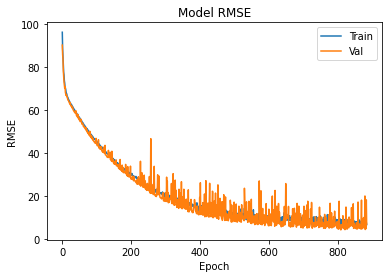

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
plt.savefig('Training.svg', dpi = 600)



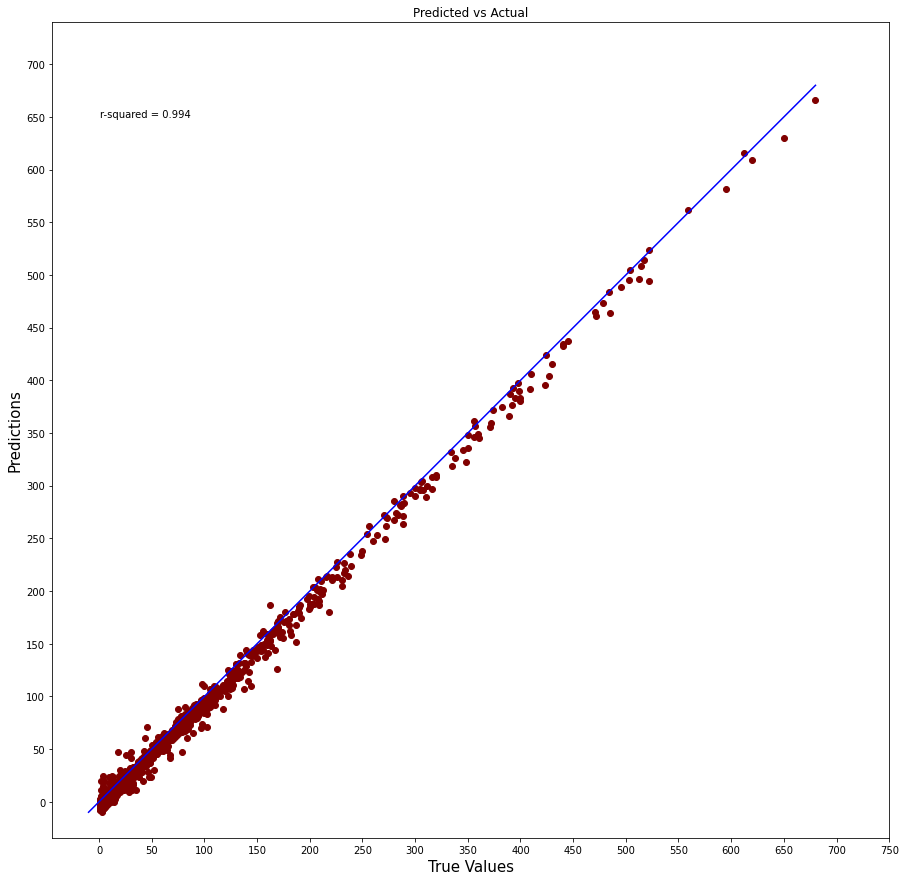

In [45]:
from sklearn.metrics import r2_score
true_value = Y
predicted_value = model.predict(X)

plt.figure(figsize=(15,15))
plt.scatter(true_value, predicted_value, c='maroon')
plt.yscale('linear')
plt.xscale('linear')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'blue')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title('Predicted vs Actual')
plt.annotate("r-squared = {:.3f}".format(r2_score(true_value, predicted_value)), (1,650), )
plt.xticks( range(0,800,50) )
plt.yticks( range(0,800,50) )
#plt.show()
plt.savefig('P_A.svg', dpi = 1200)

In [ ]:
#@title Insert PubChem Fingerprint of Drug and Carrier (Oil, Surfactant, Cosurfactant)
!pip install pubchempy
import tensorflow as tf
import pandas as pd 
import numpy as np 
import io
from tensorflow import keras
import pubchempy as pcp
from sklearn.preprocessing import OneHotEncoder
from keras.models import load_model
import time as tm
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1TG-Ati7Za3NUUMP48kPiCoydanpjYCBI',
                                    dest_path='/content/sample_data/Sol_ME.hdf5',
                                    unzip=False)
#Load Model
model = load_model('/content/sample_data/Sol_ME.hdf5', compile= True)


Drug_CID =  71771#@param {type:"number"}
Excipient_CID =  8042#@param {type:"number"}


CID_D = pcp.Compound.from_cid(Drug_CID)
CID_E = pcp.Compound.from_cid(Excipient_CID)

FPD = CID_D.cactvs_fingerprint
FPE = CID_E.cactvs_fingerprint
List1 = list(FPD)
List2 = list(FPE)
List = List1 + List2
 
import pandas as pd
t = pd.DataFrame(np.array(List).reshape(-1,len(List)))
 
#@title RUN FOR PREDICTION
 
 
dataset1 = t.values
t.dtype = int
X_Predict = (dataset1[:,0:1762].astype(int))
print(X_Predict)
print(X_Predict.shape)
print(X_Predict.dtype)
 
Y_prediction = model.predict(X_Predict)
 
print(Y_prediction, "mg/ml")